### Abstract

The problem statement I chose to solve is 2. Bike Sharing Demand

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

In this problem, you are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.


### Brief Literature Survey

A Brief survey over the internet about the dataset leads to the source, the UCI Machine Learning Repository, which is my go-to site for getting datasets https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#

The abstract description there gives us a huge insight on how to understand the data and how to approach the task

Data Set Characteristics: Univariate

Area: Social

Attribute Characteristics: Integer, Real

Associated Tasks: Regression

* Packages used: 
    - numpy
    - pandas
    - sklearn
    - seaborn
    - matplotlib
    
The following link from the sklearn documentation gave me insight on how to choose a fitting estimator
http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

#### The following is the attribute information

* datetime - hourwise date and time 
* season : season (1:springer, 2:summer, 3:fall, 4:winter)
* holiday - whether day is a holiday or not
* workingday - if day is neither weekend nor holiday is 1, otherwise is 0.
* weather - 
    * 1: Clear, Few clouds, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - Normalized temperature in Celsius.
* atemp - Normalized feeling temperature in Celsius.
* humidity - humidity
* windspeed - wind speed
* casual - number of non-registered(casual) users
* registered - number of registered users
* count - number of total rental bikes (Target Variable)

#### Relevant Papers:

[1] Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg


#### Data​ ​Characterization

The Dataset is provided in .csv format so to read it on the notebook, the pandas package is used.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 


data = pd.read_csv('train.csv')

In [40]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### Shape of the dataset

In [41]:
data.shape

(10886, 12)

#### Variable Data Types

In [42]:
data.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### Feature Engineering

* Since the 'datetime' column is pretty much un-usable in the given format, it makes sense to split it up and create new columns so that we can use the data

In [43]:
temp_t=pd.DatetimeIndex(data['datetime'])
data["dayofweek"] = temp_t.dayofweek
data["hour"] = temp_t.hour
data["month"] = temp_t.month
data['year']= temp_t.year

In [44]:
data.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dayofweek,hour,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,5,0,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,5,1,1,2011


* Checking Null values

In [45]:
data.isnull().values.any()

False

Luckily we dont have any missing value in the dataset. 

#### Correlation analysis

Before building predictive models, it is useful to find out the relationship of all predictors with target variable. 
The correlation plot below shows that.

In [46]:
import seaborn as sn
%matplotlib inline
corr_matrix = data[["hour", "month", "windspeed", "temp", "atemp", 
                    "casual", "registered", "humidity", "count"]].corr()

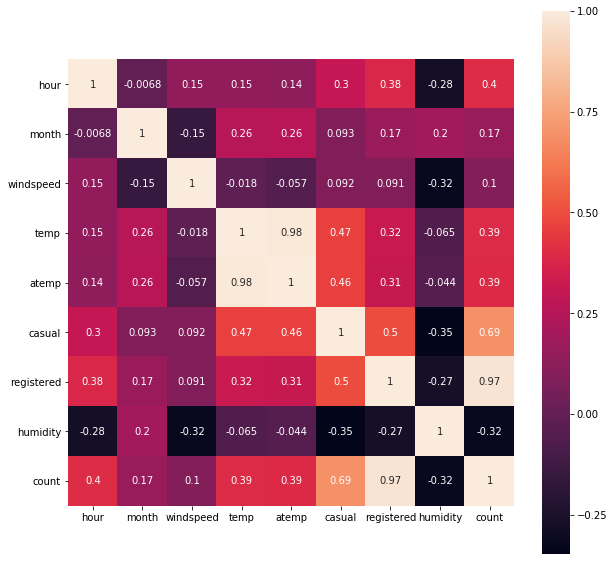

In [47]:
fig,ax= plt.subplots()
fig.set_size_inches(10,10)
sn.heatmap(corr_matrix, annot = True, square = True)

 - It makes sense to drop windspeed as the it has low correlation with count.
 - Since temp and atemp have strong correlation with each other, it is better to drop any one of them as they will exhibit multicollinearity.
 - Casual and Registered are also to be dropped for obvious reasons

#### The below plots are to visualize the trend of number of users

we will use these later to determne if the same trends continue in the test dataset too or not

Text(0.5,1,'monthly count')

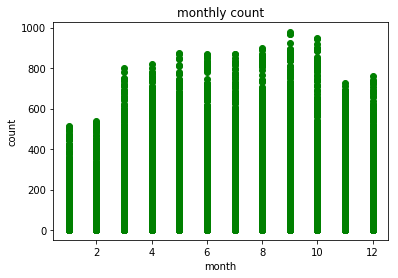

In [48]:
data.datetime = data.datetime.apply(pd.to_datetime)
month = data.datetime.apply(lambda x : x.month)

plt.scatter(month.values, data['count'], color = 'green')
plt.xlabel('month')
plt.ylabel('count')
plt.title('monthly count')

Text(0.5,1,'hourly count')

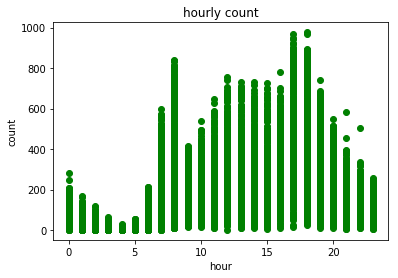

In [49]:
hours = data.datetime.apply(lambda x : x.hour)
plt.scatter(hours.values, data['count'], color = 'green')
plt.xlabel('hour')
plt.ylabel('count')
plt.title('hourly count')

Text(0.5,1,'season')

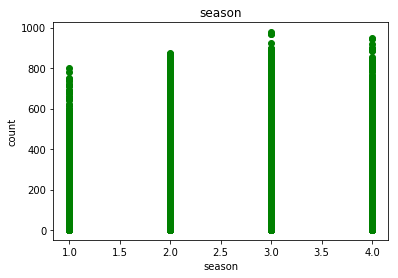

In [50]:
plt.scatter(data['season'].values, data['count'], color = 'green')
plt.xlabel('season')
plt.ylabel('count')
plt.title('season')

 - It can be observed that people tend to rent bikes during summer and fall months due to pleasant climate.
 - More people tend to rent bikes around 7AM-8AM and 5PM-6PM, this can be attributed to regular school and office commuters.

#### Visualizing Distribution Of Data

- It is observed from the below plots that "count" variable is skewed towards right;
    - This makes sense because at whole night time there were only a few bike rented, so the distribution is looks like a “part” of the normal distribution. 
- It is most desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. 
- One possible solution is to take log transformation on "count" variable and train our model to predict the log of 'count' and then revert it back.

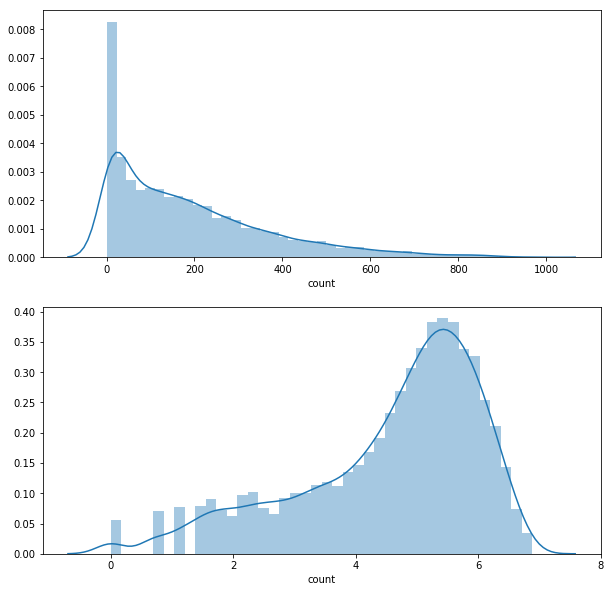

In [51]:
fig,axes = plt.subplots(nrows=2)
fig.set_size_inches(10, 10)
sn.distplot(data["count"],ax=axes[0])
sn.distplot(np.log(data["count"]),ax=axes[1])

#### Preparing Train and Test data from the given dataset

In [86]:
X = data.drop(['datetime', 'temp', 'casual','registered','count','windspeed'], axis = 1)
y = data['count']
feature_cols = list(X)

from sklearn.cross_validation import train_test_split
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.33,
                                                    random_state=10)

* Checking the dimensions of the new sets

In [87]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7293, 10)
(7293,)
(3593, 10)
(3593,)


### Model Selection 

- The model selection has been done using the flowchart provided in the official sklearn documentation.
- The inference made from flowchart is:
    * First perform linear regression
    * if not satisfactory, perform SVR (support Vector Regression)
    * If even that is not satisfactory, go for ensemble regressors like random forest regressor

#### evaluation metric
- the evaluation metric used here is root mean square logarthmic error as it is widely used and can be used when we want to penalize under estimates more than over estimates.
- We choose this method because it is used by Kaggle, all the solutions provided by users from all over the world are evaluated and ranked by RMSLE score, so it helps in comparision with other projects as well.

#### Linear Regression Model
    

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lin_reg = LinearRegression()

y_log = np.log1p(y)
y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)

lin_reg.fit(X_train,y_train_log)
y_lin_pred = lin_reg.predict(X_test)

print('RMSLE:',np.sqrt(metrics.mean_squared_log_error(y_test,
                                             np.exp(y_lin_pred))))

RMSLE: 1.03514563648


In [89]:
from sklearn.cross_validation import cross_val_score

linreg_scores = cross_val_score(lin_reg, X, y_log, cv=10, scoring='neg_mean_squared_log_error')
linreg_msle_scores = -linreg_scores
linreg_rmsle_scores = np.sqrt(linreg_msle_scores)
print(linreg_rmsle_scores)
print('RMSLE:',linreg_rmsle_scores.mean())

[ 0.29012     0.24118389  0.20063433  0.21331981  0.23111353  0.27416042
  0.23776846  0.20532665  0.19835825  0.21660653]
RMSLE: 0.230859186544


#### Support Vector Regression Model

In [90]:
from sklearn import svm

svm_reg = svm.SVR()
svm_reg.fit(X_train,y_train_log)
y_svr_pred = svm_reg.predict(X_test)

In [97]:
print('RMSLE:',np.sqrt(metrics.mean_squared_log_error(y_test, np.exp(y_svr_pred))))

RMSLE: 0.561899430521


In [96]:
svm_reg_scores = cross_val_score(svm_reg, X, y_log, cv=10, scoring='neg_mean_squared_log_error')
svm_reg_msle_scores = -svm_reg_scores
svm_reg_rmsle_scores = np.sqrt(svm_reg_msle_scores)
print(svm_reg_rmsle_scores)
print('RMSLE:',svm_reg_rmsle_scores.mean())

[ 0.32342444  0.21190286  0.12726387  0.12077832  0.19924519  0.21103899
  0.16892643  0.10850145  0.11574475  0.15357537]
RMSLE: 0.174040168174


#### Random Forest Regressor

In [98]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=21)

rf_reg.fit(X_train,y_train_log)
y_rf_pred = rf_reg.predict(X_test)

print('RMSLE:',np.sqrt(metrics.mean_squared_log_error
                       (y_test, np.exp(y_rf_pred))))

RMSLE: 0.328223600028


In [99]:
rf_reg_scores = cross_val_score(rf_reg, X, y_log, cv=10, scoring='neg_mean_squared_log_error')
rf_reg_msle_scores = -rf_reg_scores
rf_reg_rmsle_scores = np.sqrt(rf_reg_msle_scores)
print(rf_reg_rmsle_scores)
print('RMSLE:',rf_reg_rmsle_scores.mean())

[ 0.14986572  0.11820597  0.06541235  0.08581283  0.09878673  0.11421273
  0.1001766   0.06164164  0.06611076  0.07910926]
RMSLE: 0.0939334585077


* This establishes that, according to our prior inference, random forest regressor performs better than both SVR and Linear Regressor

### Parameter Tuning

* The main parameters to adjust when using these methods is n_estimators and max_features. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. 
* In addition, note that results will stop getting significantly better beyond a critical number of trees. The latter is the size of the random subsets of features to consider when splitting a node. 
* The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are max_features=number of features for regression problems

Here, we are iterating over the range of 5-50 for the value of estimators(trees) to see how the mean score varies.

In [102]:
k_range = list(range(5, 100))
k_scores = []
for k in k_range:
    rfModel = RandomForestRegressor(n_estimators=k)
    scores = cross_val_score(rfModel, X, y, cv=10, scoring='neg_mean_squared_log_error')
    k_scores.append(-scores.mean())

Text(0,0.5,'log error')

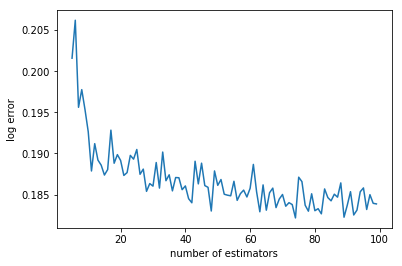

In [103]:
%matplotlib inline
plt.plot(k_range, k_scores)
plt.xlabel('number of estimators')
plt.ylabel('log error')

* From the above we can infer that the number of estimators = 40 to get the best performance-delay tradeoff for random forest regressor

### Performance of each model

|       Learning Model      | using train_test_split | using cross_validation |
|:-------------------------:|:----------------------:|:----------------------:|
|     Linear Regression     |      1.03514563648     |     0.230859186544     |
| Support Vector Reggressor |     0.561899430521     |     0.174040168174     |
|  Random Forest Regressor  |     0.328223600028     |     0.0939334585077    |


- the performance is measured by testing the model by using both 
    * cross_validation.train_test_split 
    * cross_validation.cross_val_score with no of folds = 10
    
### Conclusion: Making Final Prediction    

load the test.csv dataset to predict the count for each hour

In [120]:
test_data = pd.read_csv('test.csv')
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [121]:
temp_test=pd.DatetimeIndex(test_data['datetime'])
test_data["dayofweek"] = temp_test.dayofweek
test_data["hour"] = temp_test.hour
test_data["month"] = temp_test.month
test_data['year']= temp_test.year

test_X = test_data.drop(['datetime', 'temp','windspeed'], axis = 1)

final_prediction = rf_reg.predict(test_X)

out_data = test_data
out_data['count'] = np.exp(final_prediction)

out_data = out_data.drop(['temp','windspeed'], axis = 1)

out_data.head()

,datetime,season,holiday,workingday,weather,atemp,humidity,dayofweek,hour,month,year,count
0,2011-01-20 00:00:00,1,0,1,1,11.365,56,3,0,1,2011,11.889932
1,2011-01-20 01:00:00,1,0,1,1,13.635,56,3,1,1,2011,7.047423
2,2011-01-20 02:00:00,1,0,1,1,13.635,56,3,2,1,2011,4.305824
3,2011-01-20 03:00:00,1,0,1,1,12.880,56,3,3,1,2011,3.787759
4,2011-01-20 04:00:00,1,0,1,1,12.880,56,3,4,1,2011,3.122165


#### Above is the final table which contains the predicted count values

#### Now to see and verify if the predicted counts also follow similar trends as the training data

Text(0.5,1,'monthly count')

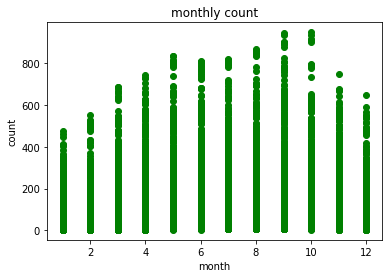

In [122]:
out_data.datetime = out_data.datetime.apply(pd.to_datetime)
month = out_data.datetime.apply(lambda x : x.month)

plt.scatter(month.values, out_data['count'], color = 'green')
plt.xlabel('month')
plt.ylabel('count')
plt.title('monthly count')

Text(0.5,1,'hourly count')

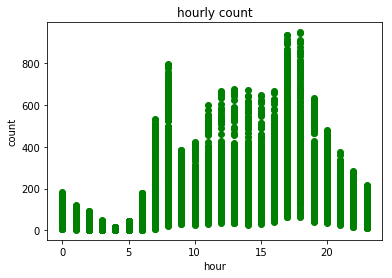

In [123]:
hours = out_data.datetime.apply(lambda x : x.hour)
plt.scatter(hours.values, out_data['count'], color = 'green')
plt.xlabel('hour')
plt.ylabel('count')
plt.title('hourly count')

Text(0.5,1,'season')

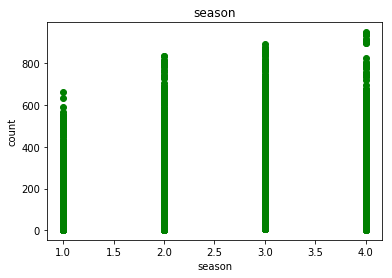

In [124]:
plt.scatter(out_data['season'].values, out_data['count'], color = 'green')
plt.xlabel('season')
plt.ylabel('count')
plt.title('season')

* We can see that the above three graphs are similar to the ones we plotted earlier with the train data, hence we can assume that the predictions were correctly made

In [133]:
submission = pd.DataFrame({'datetime': out_data.datetime,
        'count': out_data.count }).to_csv('final_predictions1.csv', index=False)